# Challenge 2
***

In [1]:
# Load the packages required to run this notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import svm, preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics as sklm

%matplotlib inline

In [2]:
# Load the datasets
adventure_works = pd.read_csv('../adventure_works.csv', parse_dates = ['BirthDate'])

In [3]:
adventure_works.columns

Index(['CustomerID', 'FirstName', 'LastName', 'AddressLine1', 'City',
       'StateProvinceName', 'CountryRegionName', 'PostalCode', 'PhoneNumber',
       'BirthDate', 'Education', 'Occupation', 'Gender', 'MaritalStatus',
       'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome',
       'TotalChildren', 'YearlyIncome', 'AveMonthSpend', 'BikeBuyer', 'Age',
       'AgeGroup'],
      dtype='object')

In [4]:
# Drop columns with minimal predictive power and 'AveMonthSpend' since we don't have that at the time of evaluation
adventure_works.drop(['CustomerID', 'FirstName', 'LastName', 'AddressLine1', 'PostalCode', 'PhoneNumber',
                      'BirthDate', 'AveMonthSpend'], axis=1, inplace=True)

In [5]:
adventure_works.head()

,City,StateProvinceName,CountryRegionName,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,Age,AgeGroup
0,Rockhampton,Queensland,Australia,Bachelors,Professional,M,M,1,0,0,2,137947,0,31,Between 25 and 45 years
1,Seaford,Victoria,Australia,Bachelors,Professional,M,S,0,1,3,3,101141,1,32,Between 25 and 45 years
2,Hobart,Tasmania,Australia,Bachelors,Professional,M,M,1,1,3,3,91945,0,32,Between 25 and 45 years
3,North Ryde,New South Wales,Australia,Bachelors,Professional,F,S,0,1,0,0,86688,0,29,Between 25 and 45 years
4,Wollongong,New South Wales,Australia,Bachelors,Professional,F,S,1,4,5,5,92771,1,29,Between 25 and 45 years


In [6]:
# Check label class imbalance
adventure_works['BikeBuyer'].value_counts()

0    10949
1     5455
Name: BikeBuyer, dtype: int64

## Visualizing class separation by numeric features

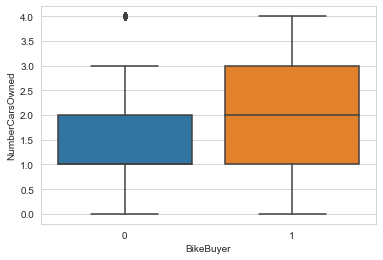

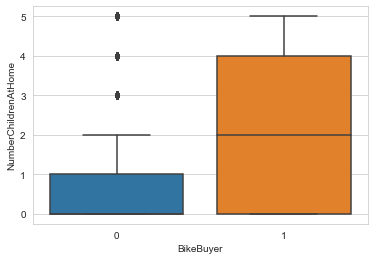

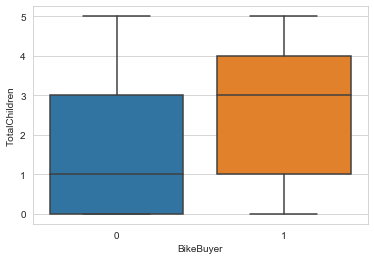

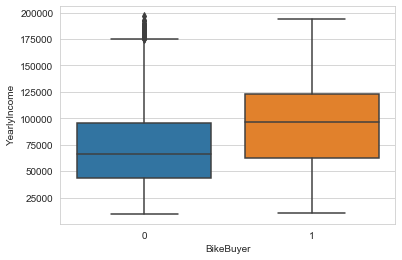

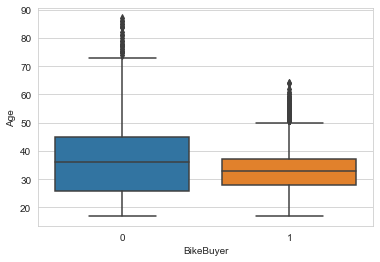

In [7]:
def plot_box(adventure_works, cols, col_x = 'BikeBuyer'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(col_x, col, data=adventure_works)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

num_cols = ['NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'YearlyIncome', 'Age']
plot_box(adventure_works, num_cols)

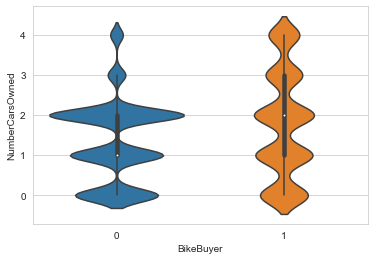

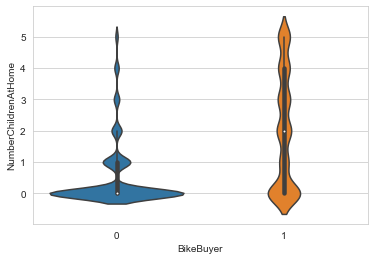

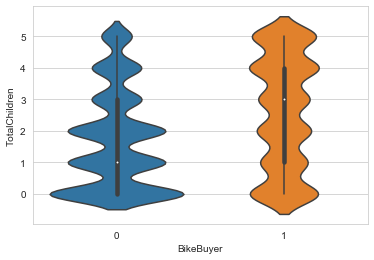

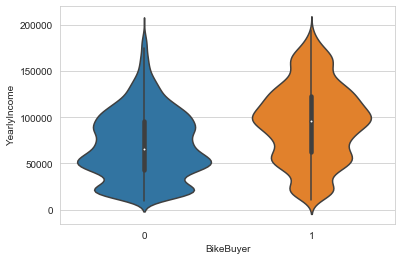

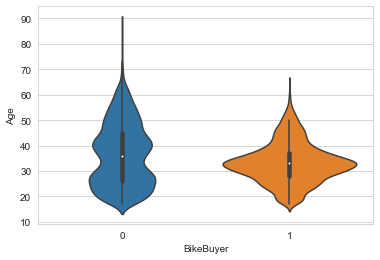

In [8]:
def plot_violin(adventure_works, cols, col_x = 'BikeBuyer'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.violinplot(col_x, col, data=adventure_works)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

plot_violin(adventure_works, num_cols)

## Visualizing class separation by categorical features

City


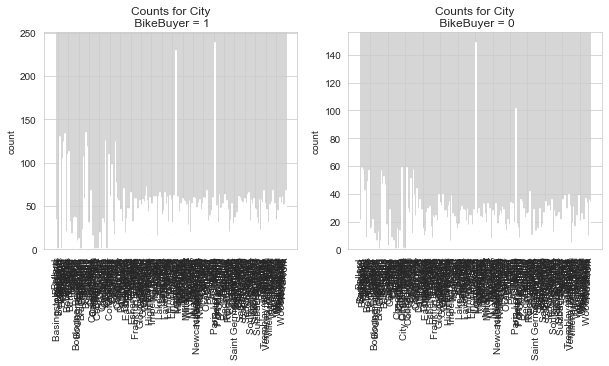

StateProvinceName


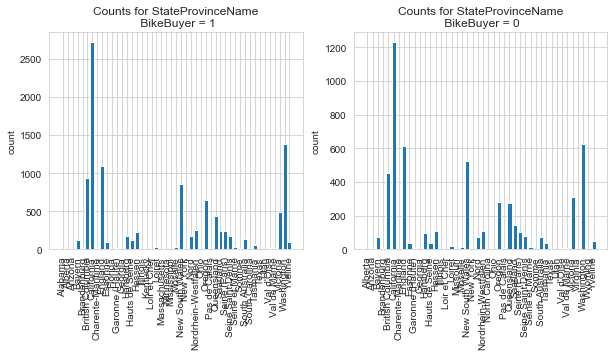

CountryRegionName


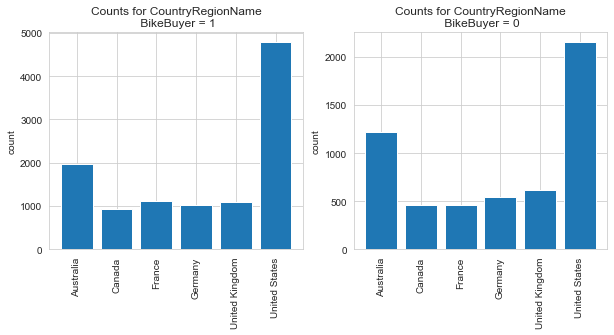

Education


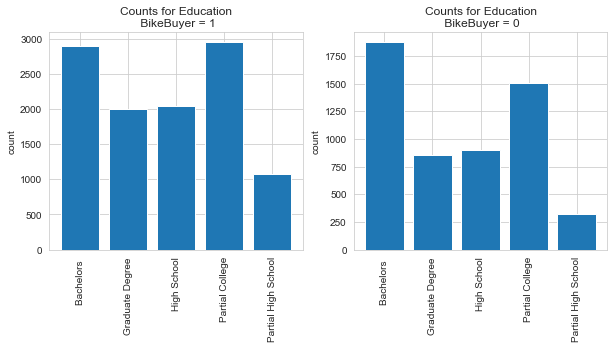

Occupation


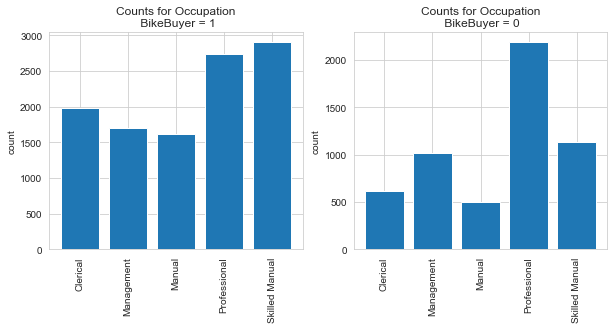

Gender


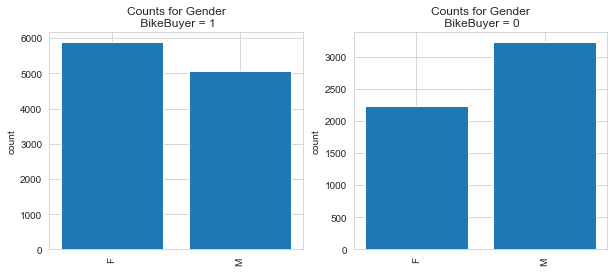

MaritalStatus


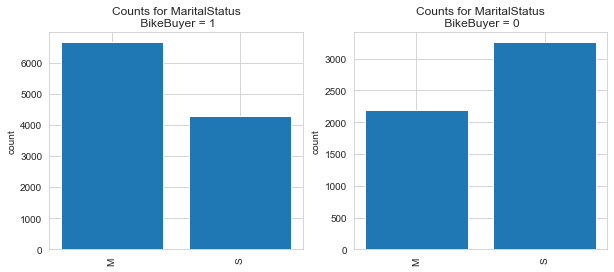

HomeOwnerFlag


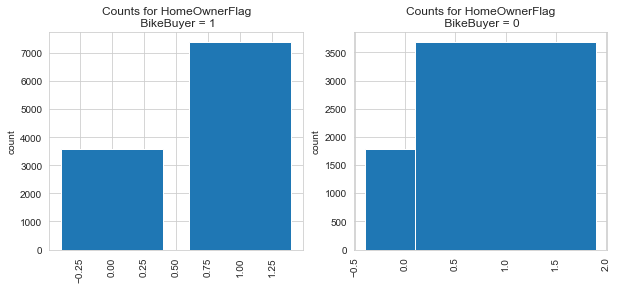

AgeGroup


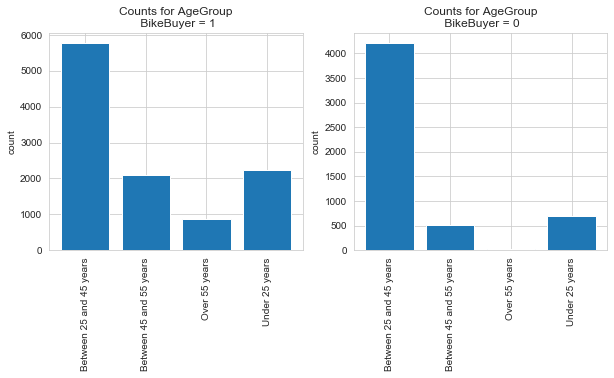

In [9]:
import numpy as np
cat_cols = ['City', 'StateProvinceName', 'CountryRegionName', 'Education', 
            'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 'AgeGroup']

adventure_works['dummy'] = np.ones(shape = adventure_works.shape[0])
for col in cat_cols:
    print(col)
    counts = adventure_works[['dummy', 'BikeBuyer', col]].groupby(['BikeBuyer', col], as_index = False).count()
    temp = counts[counts['BikeBuyer'] == 0][[col, 'dummy']]
    _ = plt.figure(figsize = (10,4))
    plt.subplot(1, 2, 1)
    temp = counts[counts['BikeBuyer'] == 0][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n BikeBuyer = 1')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    temp = counts[counts['BikeBuyer'] == 1][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n BikeBuyer = 0')
    plt.ylabel('count')
    plt.show()

## Visualizing distribution of numeric features

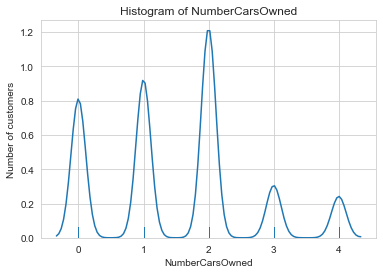

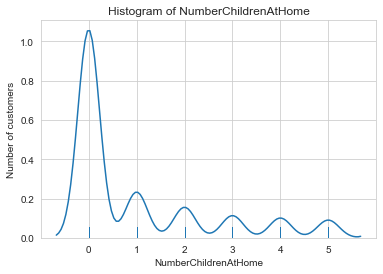

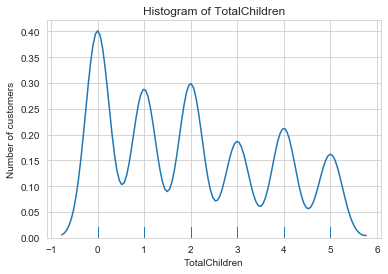

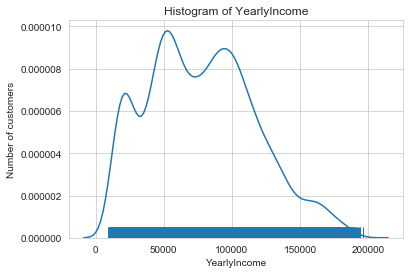

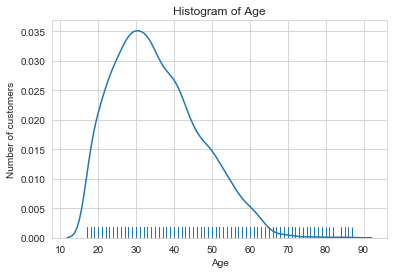

In [10]:
def plot_density_hist(adventure_works, cols, bins = 10, hist = False):
    for col in cols:
        sns.set_style("whitegrid")
        sns.distplot(adventure_works[col], bins = bins, rug=True, hist = hist)
        plt.title('Histogram of ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel('Number of customers')# Set text for y axis
        plt.show()
        
plot_density_hist(adventure_works, num_cols) 

## Prepare data for scikit-learn model

In [11]:
# Create numpy array of label values
Labels = np.array(adventure_works['BikeBuyer'])
Labels = Labels.reshape(Labels.shape[0],)

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Create model matrix
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['Occupation', 'Gender', 
                       'MaritalStatus', 'AgeGroup']

Features = encode_string(adventure_works['Education'])
for col in categorical_columns:
    temp = encode_string(adventure_works[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(16404, 18)
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.]]


In [13]:
# Concatenate numeric features to model matrix
Features = np.concatenate([Features, np.array(adventure_works[['NumberCarsOwned', 'NumberChildrenAtHome', 
                            'TotalChildren', 'YearlyIncome']])], axis = 1)
print(Features.shape)
print(Features[:2, :])

(16404, 22)
[[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 2.00000e+00 1.37947e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 3.00000e+00 3.00000e+00 1.01141e+05]]


In [14]:
print(Features.shape)
print(Labels.shape)

(16404, 22)
(16404,)


# `Logistic Regression Model`

In [15]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13123, 22)
(13123,)
(3281, 22)
(3281,)


In [17]:
# Check class imbalance in train and test split
print(pd.DataFrame(y_train)[0].value_counts())
print(pd.DataFrame(y_test)[0].value_counts())

0    8748
1    4375
Name: 0, dtype: int64
0    2201
1    1080
Name: 0, dtype: int64


In [18]:
# Scale numeric features
scaler = preprocessing.StandardScaler().fit(X_train[:,21:])
X_train[:,21:] = scaler.transform(X_train[:,21:])
X_test[:,21:] = scaler.transform(X_test[:,21:])
X_train[:2,]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  3.        ,  1.        ,
         1.        ,  1.99693131],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.        ,
         2.        , -0.5993798 ]])

In [19]:
# Define and fit a weighted logistic regression model due to class imbalance
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.45, 1: 0.55}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# Print logistic regression model coefficients
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-0.80472314]
[[ 0.04636068  0.03534877 -0.26443278 -0.10301132 -0.5189885  -0.24070949
  -0.31837449 -0.19245474 -0.00662965 -0.04655478 -0.76608237 -0.03864077
  -1.1643671   0.35964396  0.82797508 -0.26210508 -1.81476243  0.44416929
  -0.01882805  0.76840536 -0.04042345  0.39358741]]


In [21]:
# Compute probabilities and score model
probabilities = logistic_mod.predict_proba(X_test)
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
[1 0 1 1 0 0 0 0 0 0 0 1 0 0 0]


In [22]:
# Print several metrics for classification
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
    
print_metrics(y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive      1896               305
Actual negative       405               675

Accuracy  0.78
 
           Positive      Negative
Num case     2201          1080
Precision    0.82          0.69
Recall       0.86          0.62
F1           0.84          0.66


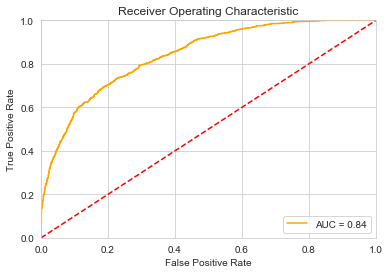

In [23]:
# Plot ROC curve with AUC
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)    

### Evaluating logistic regression model on AW_test.csv

In [24]:
evaluation = pd.read_csv('../Resources/AW_test.csv', parse_dates = ['BirthDate'])
evaluation.columns

Index(['CustomerID', 'Title', 'FirstName', 'MiddleName', 'LastName', 'Suffix',
       'AddressLine1', 'AddressLine2', 'City', 'StateProvinceName',
       'CountryRegionName', 'PostalCode', 'PhoneNumber', 'BirthDate',
       'Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag',
       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren',
       'YearlyIncome'],
      dtype='object')

In [25]:
# Prepare evaluation data for scikit-learn model
evaluation['Age'] = (pd.to_datetime("1998-01-01") - evaluation['BirthDate']) / np.timedelta64(1,'Y')
evaluation['Age'] = evaluation['Age'].astype('int64')

# Categorize customers in specific age groups
def age_group(row):
    if row['Age'] < 25:
        return "Under 25 years"
    if row['Age'] >= 25 and row['Age'] < 45:
        return "Between 25 and 45 years"
    if row['Age'] >= 45 and row['Age'] <= 55:
        return "Between 45 and 55 years"
    else:
        return "Over 55 years"

evaluation['AgeGroup'] = evaluation.apply(lambda row: age_group(row), axis=1)
evaluation['AgeGroup'].unique()

array(['Between 45 and 55 years', 'Between 25 and 45 years',
       'Over 55 years', 'Under 25 years'], dtype=object)

In [26]:
evaluation.drop(['CustomerID', 'Title', 'FirstName', 'MiddleName', 'LastName', 'Suffix', 'AddressLine1', 
                 'AddressLine2', 'City', 'StateProvinceName', 'CountryRegionName', 'PostalCode', 'PhoneNumber',
                 'BirthDate', 'Age'], axis=1, inplace=True)

In [27]:
evaluation.tail()

,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AgeGroup
495,Graduate Degree,Skilled Manual,F,S,0,0,0,0,97084,Between 25 and 45 years
496,Partial College,Management,F,S,0,4,4,4,110762,Between 45 and 55 years
497,Bachelors,Management,F,S,0,4,3,3,138097,Over 55 years
498,Partial College,Professional,F,M,1,1,0,2,101465,Between 25 and 45 years
499,High School,Skilled Manual,F,S,0,2,0,4,19108,Between 45 and 55 years


In [28]:
# Create model matrix for final evaluation on AW_test
categorical_columns = ['Occupation', 'Gender', 
                       'MaritalStatus', 'AgeGroup']

AW_test = encode_string(evaluation['Education'])
for col in categorical_columns:
    temp = encode_string(evaluation[col])
    AW_test = np.concatenate([AW_test, temp], axis = 1)

# Concatenate numeric features to model matrix
AW_test = np.concatenate([AW_test, np.array(evaluation[['NumberCarsOwned', 'NumberChildrenAtHome', 
                            'TotalChildren', 'YearlyIncome']])], axis = 1)
# Scale numeric features using same scalar object for train data
AW_test[:,21:] = scaler.transform(AW_test[:,21:])

In [29]:
probabilities = logistic_mod.predict_proba(AW_test)
scores = score_model(probabilities, 0.5)
print(pd.DataFrame(scores))
# pd.DataFrame(scores).to_csv('challenge2_predictions.csv', sep = "\n", index = False, header = False)

## Note: 0.786 accuracy on Aw_test.csv

     0
0    0
1    1
2    0
3    0
4    0
..  ..
495  0
496  1
497  0
498  0
499  0

[500 rows x 1 columns]


# `Random Forest Model - Bagging`

In [30]:
# Define inside and outside fold object
nr.seed(123)
inside = ms.KFold(n_splits=4, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=4, shuffle = True)

In [31]:
## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_features": [2, 3, 5, 10, 15], "min_samples_leaf":[3, 5, 10, 20]}
## Define the random forest model
nr.seed(3456)
rf_clf = RandomForestClassifier(class_weight = "balanced") 

## Perform the grid search over the parameters
nr.seed(4455)
rf_clf = ms.GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)
rf_clf.fit(Features, Labels)
print(rf_clf.best_estimator_.max_features)
print(rf_clf.best_estimator_.min_samples_leaf)

5
20


In [32]:
# Perform outer loop of nested cross validation to evaluate model performance
nr.seed(498)
cv_estimate = ms.cross_val_score(rf_clf, Features, Labels, 
                                 cv = outside) # Use the outside folds

print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.849
SDT of the metric       = 0.002
Outcomes by cv fold
Fold  1    0.846
Fold  2    0.849
Fold  3    0.852
Fold  4    0.849


In [33]:
# Define and fit a random forest model with the optimal hyperparameters using train features and labels created earlier
nr.seed(1115)
rf_mod = RandomForestClassifier(class_weight = "balanced", 
                                max_features = rf_clf.best_estimator_.max_features, 
                                min_samples_leaf = rf_clf.best_estimator_.min_samples_leaf) 
rf_mod.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [34]:
# Compute probabilities and score model using test features and labels created earlier
probabilities = rf_mod.predict_proba(X_test)
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 1 0 0 0 0 0 0 0 1 0 0 0]
[1 0 1 1 0 0 0 0 0 0 0 1 0 0 0]


In [35]:
print_metrics(y_test, scores)

                 Confusion matrix
                 Score positive    Score negative
Actual positive      1707               494
Actual negative       280               800

Accuracy  0.76
 
           Positive      Negative
Num case     2201          1080
Precision    0.86          0.62
Recall       0.78          0.74
F1           0.82          0.67


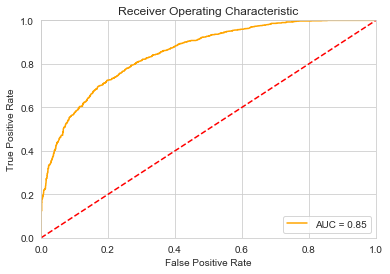

In [36]:
plot_auc(y_test, probabilities)  

### Evaluating random forest model on AW_test.csv

In [37]:
probabilities = rf_mod.predict_proba(AW_test)
scores = score_model(probabilities, 0.5)
print(pd.DataFrame(scores))
# pd.DataFrame(scores).to_csv('challenge2_predictions.csv', sep = "\n", index = False, header = False)

## Note: 0.782 accuracy on Aw_test.csv

     0
0    0
1    1
2    0
3    0
4    0
..  ..
495  1
496  1
497  1
498  0
499  0

[500 rows x 1 columns]


# `Boosted Decision Trees - AdaBoost`

In [38]:
# Define inside and outside fold object
nr.seed(123)
inside = ms.KFold(n_splits=4, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=4, shuffle = True)

In [39]:
## Define the dictionary for the grid search and the model object to search on
param_grid = {"learning_rate": [0.1, 1, 10]}
## Define the AdaBoosted tree model
nr.seed(3456)
ab_clf = AdaBoostClassifier()  

## Perform the grid search over the parameters
nr.seed(4455)
ab_clf = ms.GridSearchCV(estimator = ab_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)
ab_clf.fit(Features, Labels)
print(ab_clf.best_estimator_.learning_rate)

1


In [40]:
# Perform outer loop of nested cross validation to evaluate model performance
nr.seed(498)
cv_estimate = ms.cross_val_score(ab_clf, Features, Labels, 
                                 cv = outside) # Use the outside folds

print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.843
SDT of the metric       = 0.002
Outcomes by cv fold
Fold  1    0.840
Fold  2    0.846
Fold  3    0.843
Fold  4    0.844


In [41]:
# Define and fit a boosted decision tree model with the optimal hyperparameters using train features and labels created earlier
nr.seed(1115)
ab_mod = AdaBoostClassifier(learning_rate = ab_clf.best_estimator_.learning_rate) 
ab_mod.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

In [42]:
# Compute probabilities and score model using test features and labels created earlier
probabilities = ab_mod.predict_proba(X_test)
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
[1 0 1 1 0 0 0 0 0 0 0 1 0 0 0]


In [43]:
print_metrics(y_test, scores)

                 Confusion matrix
                 Score positive    Score negative
Actual positive      1916               285
Actual negative       418               662

Accuracy  0.79
 
           Positive      Negative
Num case     2201          1080
Precision    0.82          0.70
Recall       0.87          0.61
F1           0.84          0.65


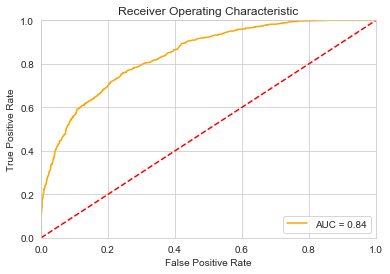

In [44]:
plot_auc(y_test, probabilities)  

### Evaluating random forest model on AW_test.csv

In [45]:
probabilities = ab_mod.predict_proba(AW_test)
scores = score_model(probabilities, 0.5)
print(pd.DataFrame(scores))
# pd.DataFrame(scores).to_csv('challenge2_predictions.csv', sep = "\n", index = False, header = False)

## Note: 0.786 accuracy on Aw_test.csv

     0
0    0
1    1
2    0
3    0
4    0
..  ..
495  0
496  1
497  0
498  0
499  0

[500 rows x 1 columns]
